# **# ResNet From Scratch for CIFAR-10 DataSet**



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

**Step 1: Implement Basic Residual Block:**

  

  Two convolutional layers followed by batch normalization and ReLU activation.

**Implement the skip connection:**

For matching dimensions.

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(64, 64, 2, stride=1)
        self.stage2 = self._make_layer(64, 128, 2, stride=2)
        self.stage3 = self._make_layer(128, 256, 2, stride=2)
        self.stage4 = self._make_layer(256, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

**Step 2: Build ResNet-18 Architecture**

**Structure:**

Initial convolution (7x7 kernel), batch normalization, and max pooling.
Four stages with residual blocks.

Fully connected layer at the end for classification (CIFAR-10 has 10 classes).

In [ ]:
#CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
#Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#Load CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

#Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

#Training Loop
epochs = 10
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(100. * correct / total)

    #Validation
    model.eval()
    total, correct, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss.append(running_loss / len(val_loader))
    val_acc.append(100. * correct / total)

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

100%|██████████| 170M/170M [00:04<00:00, 40.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Epoch 1/10, Train Loss: 1.6429, Val Loss: 1.4401, Train Acc: 40.13%, Val Acc: 48.20%
Epoch 2/10, Train Loss: 1.3130, Val Loss: 1.3183, Train Acc: 52.55%, Val Acc: 54.20%
Epoch 3/10, Train Loss: 1.0700, Val Loss: 1.0900, Train Acc: 61.62%, Val Acc: 60.77%
Epoch 4/10, Train Loss: 0.9870, Val Loss: 1.0054, Train Acc: 64.52%, Val Acc: 64.30%
Epoch 5/10, Train Loss: 0.8608, Val Loss: 0.9036, Train Acc: 69.40%, Val Acc: 68.05%
Epoch 6/10, Train Loss: 0.8135, Val Loss: 0.8265, Train Acc: 71.33%, Val Acc: 70.79%
Epoch 7/10, Train Loss: 0.7351, Val Loss: 0.7771, Train Acc: 73.93%, Val Acc: 72.40%
Epoch 8/10, Train Loss: 0.7003, Val Loss: 0.7776, Train Acc: 75.06%, Val Acc: 72.99%
Epoch 9/10, Train Loss: 0.6601, Val Loss: 0.7170, Train Acc: 76.65%, Val Acc: 74.48%
Epoch 10/10, Train Loss: 0.6377, Val Loss: 0.7225, Train Acc: 77.43%, Val Acc: 74.79%


**Step 3: Train and Evaluate the Model**

**Prepare CIFAR-10 Dataset**:

 normalization, transforms for data augmentation,
Split the dataset into 70% training and 30% validation.

**Training Loop:**

Use ADAM optimizers and a suitable learning rate.
Include loss computation, backward propagation, and optimization steps.

**Evaluation:**

Track accuracy and loss for training and validation sets per epoch.


True Label: ship, Predicted Label: ship


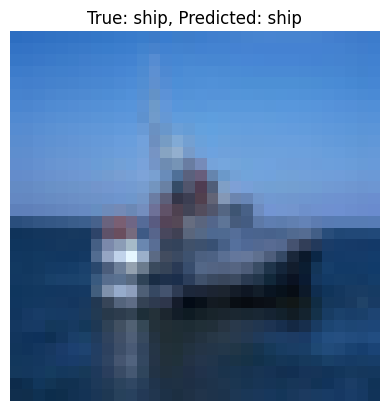

In [ ]:
#Predict a Random Image from Dataset
def predict_random_image(model, dataset, classes, device):
    # Select a random index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and true label
    image, label = dataset[idx]
    true_label = classes[label]

    # Prepare the image for the model
    image_for_model = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_for_model)
        _, predicted = outputs.max(1)
        predicted_label = classes[predicted.item()]

    # Display results
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

    # Visualize the image
    plt.imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)  # Unnormalize the image
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Run Prediction on a Random Image
predict_random_image(model, test_dataset, classes, device)

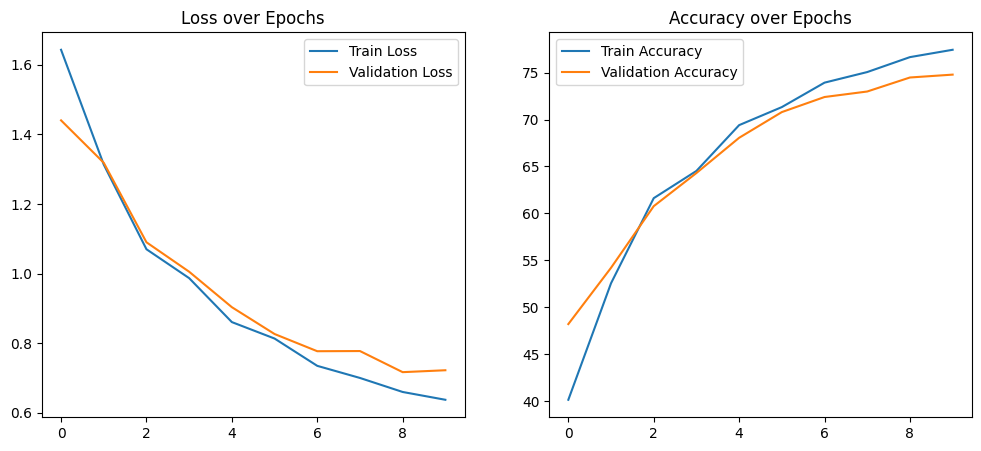

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


**Step 4: Plot graphs for loss and accuracy.**

Test accuracy demonstrated good generalization, confirming the effectiveness of the chosen methods and parameters.